# Context
The dataset comes from Kaggle https://inclass.kaggle.com/jordangoblet/atp-tour-20002016, and has been compiled from various sources.

It contains relatively high level data about all tennis games on the ATP tour, like the date of the game, names of both players, who won, their ranks, the type of surface, the name of the tournament...

There is some other data (which I don't think I"ll use) such as:
* The breakdown of the scores eg 6-4 6-4 6-4
* Various betting odds from various betting companies

To recap:
* we're trying to predict who will win a given tennis match, based on the information available. We will have to compute derived features that represent the user's past performance, as the information available upfront for a given tennis match is relatively limited
* A baseline could be based on the current ATP ranking (ie the better ranked player should win)

# 1/ Basic look at the data + Cleaning data (converting types and removing NAs)

In [1]:
import pandas as pd, numpy as np
import importlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (12,8)

In [2]:
import sys
sys.path.append("../../")
# Importing my helper module
from tennis_predictor import clean_data

In [3]:
df = pd.read_csv("../../data.csv", low_memory=False)
COLUMNS = [
    "Location", "Tournament", "Date",
    "Series",
    "Court", "Surface",
    "Round", "Best of",
    "Winner", "Loser", "WRank", "LRank",
]
GAME_STATS_COLS = [
    "W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5",
    "Wsets", "Lsets"
]
df = df[COLUMNS + GAME_STATS_COLS]

## 1.A An example record

In [4]:
# Example record
df.iloc[377]

Location                 Memphis
Tournament       Kroger St. Jude
Date                  14/02/2000
Series        International Gold
Court                     Indoor
Surface                     Hard
Round                  1st Round
Best of                        3
Winner                 Mamiit C.
Loser                  Jensen L.
WRank                        135
LRank                         NR
W1                             7
L1                             5
W2                             6
L2                             2
W3                           NaN
L3                           NaN
W4                           NaN
L4                           NaN
W5                           NaN
L5                           NaN
Wsets                          2
Lsets                          0
Name: 377, dtype: object

## 1.B Converting to the appropriate data types, dropping rows with NAs

In [5]:
data = clean_data.convert_to_numeric(df, ["WRank", "LRank"])
data = data.assign(
    Date=pd.to_datetime(data.Date, format="%d/%m/%Y")
)
data = clean_data.drop_nas(data, COLUMNS)  # This will also print a summary of where we had NAs

Location       0
Tournament     0
Date           0
Series         0
Court          0
Surface        0
Round          0
Best of        0
Winner         0
Loser          0
WRank         16
LRank         98
dtype: int64


## 1.C Inspecting the data

In [6]:
data.Series.value_counts()

International           11846
ATP250                   8947
Grand Slam               8630
Masters                  5281
Masters 1000             4320
International Gold       3744
ATP500                   3132
International Series      398
Masters Cup               240
Name: Series, dtype: int64

In [7]:
data.iloc[:,:20].tail()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4
46647,St. Petersburg,St. Petersburg Open,2016-09-23,ATP250,Indoor,Hard,Quarterfinals,3,Zverev A.,Youzhny M.,27.0,53.0,6.0,2.0,6.0,2.0,NaN,NaN,NaN,NaN
46648,St. Petersburg,St. Petersburg Open,2016-09-23,ATP250,Indoor,Hard,Quarterfinals,3,Wawrinka S.,Troicki V.,3.0,33.0,7.0,5.0,6.0,2.0,NaN,NaN,NaN,NaN
46649,St. Petersburg,St. Petersburg Open,2016-09-24,ATP250,Indoor,Hard,Semifinals,3,Zverev A.,Berdych T.,27.0,9.0,6.0,4.0,6.0,4.0,NaN,NaN,NaN,NaN
46650,St. Petersburg,St. Petersburg Open,2016-09-24,ATP250,Indoor,Hard,Semifinals,3,Wawrinka S.,Bautista Agut R.,3.0,16.0,7.0,6.0,6.0,2.0,NaN,NaN,NaN,NaN
46651,St. Petersburg,St. Petersburg Open,2016-09-25,ATP250,Indoor,Hard,The Final,3,Zverev A.,Wawrinka S.,27.0,3.0,6.0,2.0,3.0,6.0,7.0,5.0,NaN,NaN


In [8]:
data.iloc[:,20:].head()

,W5,L5,Wsets,Lsets
0,NaN,NaN,2.0,0.0
1,NaN,NaN,2.0,0.0
2,NaN,NaN,2.0,1.0
3,NaN,NaN,2.0,0.0
4,NaN,NaN,2.0,1.0


In [9]:
data.dtypes, data.shape

(Location              object
 Tournament            object
 Date          datetime64[ns]
 Series                object
 Court                 object
 Surface               object
 Round                 object
 Best of                int64
 Winner                object
 Loser                 object
 WRank                float64
 LRank                float64
 W1                   float64
 L1                   float64
 W2                   float64
 L2                   float64
 W3                   float64
 L3                   float64
 W4                   float64
 L4                   float64
 W5                   float64
 L5                   float64
 Wsets                float64
 Lsets                float64
 dtype: object, (46538, 24))

## 1.D Baseline: Does the better ranked player always win?

In [10]:
matches_where_better_wins = data[data.WRank < data.LRank].shape[0]
matches_where_better_wins / data.shape[0]

0.6568395719626972

### They do about 65% of the time !!

# 2/ Labelling players 1 and 2 (input: data Dataframe)

* The player specific columns are basically grouped into two groups: the various columns about the Winner and the various columns about the Loser
* We need to somehow pick, for each match a "Player1" and a "Player2", in a way that Player1 doesn't always win!

#### So if we pick the better player as "Player1", we know that Player1 only wins 65% of the time. If we try to predict whether Player1 wins, we have 65% of "True" and "35%" of "False"

In [11]:
# Let's basically rename columns, let the better rank player be "Player1" and the other one by "Player2"
from tennis_predictor import transform_data
P1_P2 = transform_data.number_players(data, lambda x: x.WRank < x.LRank)
print(P1_P2.shape)
P1_P2.head()

(46538, 16)


,P1_Name,P1_Rank,P1_1,P1_2,P1_3,P1_4,P1_5,P1_Sets,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets
0,Dosedel S.,63.0,6.0,6.0,NaN,NaN,NaN,2.0,Ljubicic I.,77.0,4.0,2.0,NaN,NaN,NaN,0.0
1,Enqvist T.,5.0,6.0,6.0,NaN,NaN,NaN,2.0,Clement A.,56.0,3.0,3.0,NaN,NaN,NaN,0.0
2,Escude N.,40.0,6.0,7.0,6.0,NaN,NaN,2.0,Baccanello P.,655.0,7.0,5.0,3.0,NaN,NaN,1.0
3,Federer R.,65.0,6.0,6.0,NaN,NaN,NaN,2.0,Knippschild J.,87.0,1.0,4.0,NaN,NaN,NaN,0.0
4,Fromberg R.,81.0,7.0,5.0,6.0,NaN,NaN,2.0,Woodbridge T.,198.0,6.0,7.0,4.0,NaN,NaN,1.0


#### Let's now concatenate those new columns with the other columns that we care about (the first 10 columns in data, we don't care about the rest as we just copied/renamed them)

In [12]:
data_with_P1_P2 = data.iloc[:,:10].join(P1_P2, how="inner")
print(data_with_P1_P2.shape)
data_with_P1_P2.head()

(46538, 26)


,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,...,P1_5,P1_Sets,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,...,NaN,2.0,Ljubicic I.,77.0,4.0,2.0,NaN,NaN,NaN,0.0
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,...,NaN,2.0,Clement A.,56.0,3.0,3.0,NaN,NaN,NaN,0.0
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,...,NaN,2.0,Baccanello P.,655.0,7.0,5.0,3.0,NaN,NaN,1.0
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,...,NaN,2.0,Knippschild J.,87.0,1.0,4.0,NaN,NaN,NaN,0.0
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,...,NaN,2.0,Woodbridge T.,198.0,6.0,7.0,4.0,NaN,NaN,1.0


####  Let's add the target

In [13]:
data_with_P1_P2 = data_with_P1_P2.assign(
    Player1Wins=lambda x: x.P1_Name ==  x.Winner
)

In [14]:
# Drop those as we won't need them anymore
if {"Winner", "Loser"}.intersection(data_with_P1_P2.columns):  # So that we can rerun this cell :)
    data_with_P1_P2 = data_with_P1_P2.drop(["Winner", "Loser"], axis=1)
print(data_with_P1_P2.columns)
data_with_P1_P2.Player1Wins.mean()

Index(['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'P1_Name', 'P1_Rank', 'P1_1', 'P1_2', 'P1_3', 'P1_4', 'P1_5',
       'P1_Sets', 'P2_Name', 'P2_Rank', 'P2_1', 'P2_2', 'P2_3', 'P2_4', 'P2_5',
       'P2_Sets', 'Player1Wins'],
      dtype='object')


0.65683957196269716

# 3/ Basic EDA (input: data_with_P1_P2)

At this point I haven't decided which features exactly I'm going to use:
* derived features (that would represent the players history up to the day of the match we'd try to predict), **excluding the ranks** (the baseline might be hard to beat so here i'm trying to not use it and rather build my own features from scratch)
* the player's ranks augmented with the features above

In a first step, we can try to predict the winner using only features we already have at this point

In [15]:
eda_df = data_with_P1_P2.assign(RankDiff= lambda x: x.P2_Rank - x.P1_Rank)
corr_cols = [
    "Player1Wins", "P1_Rank", "P2_Rank", "RankDiff", "Best of"
]
eda_df[corr_cols].corr()

,Player1Wins,P1_Rank,P2_Rank,RankDiff,Best of
Player1Wins,1.000000,-0.120933,0.052750,0.088316,0.063309
P1_Rank,-0.120933,1.000000,0.356869,0.113219,-0.091759
P2_Rank,0.052750,0.356869,1.000000,0.968552,-0.027539
RankDiff,0.088316,0.113219,0.968552,1.000000,-0.004851
Best of,0.063309,-0.091759,-0.027539,-0.004851,1.000000


In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
lr = LogisticRegression()

X = eda_df[["P1_Rank", "P2_Rank", "RankDiff", "Best of"]]
Y = eda_df.Player1Wins
lr.fit(X, Y)
lr.score(X, Y)

0.65505608320082509

This makes sense, the logistic regression basically learns that P1_Rank > P2_Rank ==> P1 has a higher probability of winning. Note that we have the same precision as computed before

# 4/ Adding features derived from past history of the players (input: eda_df)

## For every point in time, we want to compute statistics about players **up until that point in time**

### Let's get a list of all the players

In [18]:
all_players = pd.concat([eda_df.P1_Name, eda_df.P2_Name])

# Divide by a bigger number to only compute data for a subset of players, can be useful to speed up things
all_players = all_players[:int(len(all_players) / 1)]  
all_players = np.append(all_players, ["Federer R.", "Nadal R.", "Djokovic N.", "Murray A."])
all_players = np.unique(all_players)
all_players.shape

(1355,)

In [19]:
from tennis_predictor import features_engineering
import importlib
importlib.reload(features_engineering)

<module 'tennis_predictor.features_engineering' from '../../tennis_predictor/features_engineering.py'>

### 4.A - Let's compute basic boolean features (extra columns) using the same index, ie tennis match resolution

So basically we're going to compute a set of boolean columns for every player!! That tell whether the player played/won that particular game, if he won what type of win it was (ie 1st Round, a Final?)

In [20]:
# Computing the columns for subsets of players at a time, to make it more manageable computation wise, and see the progress printed
# Takes about 1 minute on my Corei7 macbook from 2014
batch_size = 10 
chunks = []
for i in range(batch_size):
    players_batch = all_players[i::batch_size]
    
    # The two lines are the actual logic, we add the extra columns that say if players played/won the match
    players_stats = features_engineering.compute_games_played_and_won__fast(eda_df, players_batch)
    # Then columns saying what type of game they won if they won
    players_stats = features_engineering.compute_win_round_type__fast(players_stats, eda_df.Round, players_batch)
    
    chunks.append(players_stats.copy())
    print("Chunk {} done".format(i))
players_stats = pd.concat(chunks, axis=1, copy=False).sort_index(axis=1)

Chunk 0 done
Chunk 1 done
Chunk 2 done
Chunk 3 done
Chunk 4 done
Chunk 5 done
Chunk 6 done
Chunk 7 done
Chunk 8 done
Chunk 9 done


In [21]:
players_stats.head()

Player  Hajek J.                                                              \
Stat      Played Won Won_1st Round Won_2nd Round Won_3rd Round Won_4th Round   
0              0   0             0             0             0             0   
1              0   0             0             0             0             0   
2              0   0             0             0             0             0   
3              0   0             0             0             0             0   
4              0   0             0             0             0             0   

Player                                                                 \
Stat   Won_Quarterfinals Won_Round Robin Won_Semifinals Won_The Final   
0                      0               0              0             0   
1                      0               0              0             0   
2                      0               0              0             0   
3                      0               0              0             0   
4                      0               0              0             0   

Player      ...      van der Meer N.                                  \
Stat        ...               Played Won Won_1st Round Won_2nd Round   
0           ...                    0   0             0             0   
1           ...                    0   0             0             0   
2           ...                    0   0             0             0   
3           ...                    0   0             0             0   
4           ...                    0   0             0             0   

Player                                                                \
Stat   Won_3rd Round Won_4th Round Won_Quarterfinals Won_Round Robin   
0                  0             0                 0               0   
1                  0             0                 0               0   
2                  0             0                 0               0   
3                  0             0                 0               0   
4                  0             0                 0               0   

Player                               
Stat   Won_Semifinals Won_The Final  
0                   0             0  
1                   0             0  
2                   0             0  
3                   0             0  
4                   0             0  

[5 rows x 13550 columns]

In [22]:
nadal_played = players_stats[players_stats["Nadal R.", "Played"] == 1]["Nadal R."]  # Filtering where Nadal actually played, then keeping only its columns
french_open = eda_df[eda_df.Tournament == "French Open"]

nadal_stats = nadal_played.join(french_open, how="inner").iloc[:,:10]  # Filtering to get the French Open stats, then reselecting columns
nadal_stats = nadal_stats.join(eda_df.Date, how="inner")  # Readding the Date column
nadal_stats.head(7)

,Played,Won,Won_1st Round,Won_2nd Round,Won_3rd Round,Won_4th Round,Won_Quarterfinals,Won_Round Robin,Won_Semifinals,Won_The Final,Date
15800,1,1,1,0,0,0,0,0,0,0,2005-05-23
15868,1,1,0,1,0,0,0,0,0,0,2005-05-25
15894,1,1,0,0,1,0,0,0,0,0,2005-05-27
15910,1,1,0,0,0,1,0,0,0,0,2005-05-30
15913,1,1,0,0,0,0,1,0,0,0,2005-05-31
15917,1,1,0,0,0,0,0,0,1,0,2005-06-03
15918,1,1,0,0,0,0,0,0,0,1,2005-06-05


In [23]:
nadal_stats.resample("D", on="Date").sum().sum()
## Looks good!! As of this dataset last update, Nadal won the French Open nine times (ie he won 9 finals)

Played               75.0
Won                  72.0
Won_1st Round        12.0
Won_2nd Round        11.0
Won_3rd Round        12.0
Won_4th Round        10.0
Won_Quarterfinals     9.0
Won_Round Robin       0.0
Won_Semifinals        9.0
Won_The Final         9.0
dtype: float64

### 4.B - Let's resample with daily frequencies

In [24]:
## Let's first copy the Date column into the players_stats Dataframe
players_stats.loc(axis=1)["__OTHER__", "Date"] = eda_df.Date  ## Unfortunately I have to keep a two level column name for Date..

In [25]:
## Takes about 2 minutes
resampled_stats = players_stats.resample("D", on=("__OTHER__", "Date")).sum()
resampled_stats.head()

Player             Hajek J.                                                 \
Stat                 Played  Won Won_1st Round Won_2nd Round Won_3rd Round   
(__OTHER__, Date)                                                            
2000-01-03              0.0  0.0           0.0           0.0           0.0   
2000-01-04              NaN  NaN           NaN           NaN           NaN   
2000-01-05              NaN  NaN           NaN           NaN           NaN   
2000-01-06              NaN  NaN           NaN           NaN           NaN   
2000-01-07              NaN  NaN           NaN           NaN           NaN   

Player                                                             \
Stat              Won_4th Round Won_Quarterfinals Won_Round Robin   
(__OTHER__, Date)                                                   
2000-01-03                  0.0               0.0             0.0   
2000-01-04                  NaN               NaN             NaN   
2000-01-05                  NaN               NaN             NaN   
2000-01-06                  NaN               NaN             NaN   
2000-01-07                  NaN               NaN             NaN   

Player                                              ...      van der Meer N.  \
Stat              Won_Semifinals Won_The Final      ...               Played   
(__OTHER__, Date)                                   ...                        
2000-01-03                   0.0           0.0      ...                  0.0   
2000-01-04                   NaN           NaN      ...                  NaN   
2000-01-05                   NaN           NaN      ...                  NaN   
2000-01-06                   NaN           NaN      ...                  NaN   
2000-01-07                   NaN           NaN      ...                  NaN   

Player                                                            \
Stat               Won Won_1st Round Won_2nd Round Won_3rd Round   
(__OTHER__, Date)                                                  
2000-01-03         0.0           0.0           0.0           0.0   
2000-01-04         NaN           NaN           NaN           NaN   
2000-01-05         NaN           NaN           NaN           NaN   
2000-01-06         NaN           NaN           NaN           NaN   
2000-01-07         NaN           NaN           NaN           NaN   

Player                                                             \
Stat              Won_4th Round Won_Quarterfinals Won_Round Robin   
(__OTHER__, Date)                                                   
2000-01-03                  0.0               0.0             0.0   
2000-01-04                  NaN               NaN             NaN   
2000-01-05                  NaN               NaN             NaN   
2000-01-06                  NaN               NaN             NaN   
2000-01-07                  NaN               NaN             NaN   

Player                                          
Stat              Won_Semifinals Won_The Final  
(__OTHER__, Date)                               
2000-01-03                   0.0           0.0  
2000-01-04                   NaN           NaN  
2000-01-05                   NaN           NaN  
2000-01-06                   NaN           NaN  
2000-01-07                   NaN           NaN  

[5 rows x 13550 columns]

In [26]:
## Let's fill the NAs with 0s, we have NAs as there aren't games for every single day of the year
resampled_stats = resampled_stats.fillna(0)

#### Looking at the totals of tournament wins since the beginning of time

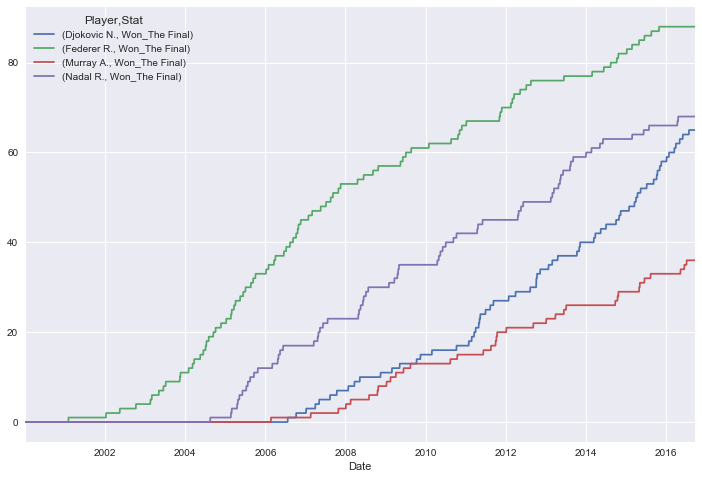

In [27]:
expanding_stats = resampled_stats.expanding().sum()

expanding_stats.sort_index(axis=1, inplace=True)
expanding_stats.index.rename("Date", inplace=True)

big4 = ["Nadal R.", "Federer R.", "Djokovic N.", "Murray A."]
expanding_stats.loc(axis=1)[big4, ["Won_The Final"]].plot()

#### Looking at the "dynamic" (1Y half life exponential weighted average)

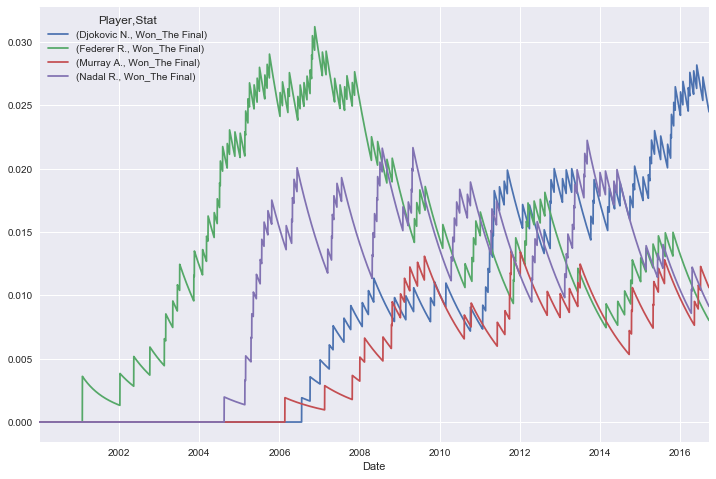

In [28]:
rolling_1Y_stats = resampled_stats.ewm(halflife=365).mean()

rolling_1Y_stats.sort_index(axis=1, inplace=True)
rolling_1Y_stats.index.rename("Date")

rolling_1Y_stats.loc(axis=1)[big4, ["Won_The Final"]].plot()

* We can clearly see that Federer has won more tournaments than any other player of the big four, but that the dynamic in the recent couple years is in favour of Djokovic
* Also we can clearly see (in both graphs) when those players started to win tournaments

## 4.C Joining that data onto the initial dataframe

Recap:
* eda_df is the initial processed dataframe (with Player1 and Player2)
* expanding_stats has the cumulative sum since the beginning of time (2000) for games played, won, 1st Round played, won etc.
* rolling_1Y_stats does an exponential moving average with a 1Y half life, looking at the "recent dynamics" of the players

### First step let's melt the expanding stats and rolling_1Y_stats

In [29]:
date_player_to_expanding_stats = expanding_stats.stack(level=0)
date_player_to_expanding_stats.head()

Stat                      Played  Won  Won_1st Round  Won_2nd Round  \
Date       Player                                                     
2000-01-03  Hajek J.         0.0  0.0            0.0            0.0   
           Abdulla M.        0.0  0.0            0.0            0.0   
           Abel M.           0.0  0.0            0.0            0.0   
           Acasuso J.        0.0  0.0            0.0            0.0   
           Adaktusson J.     0.0  0.0            0.0            0.0   

Stat                      Won_3rd Round  Won_4th Round  Won_Quarterfinals  \
Date       Player                                                           
2000-01-03  Hajek J.                0.0            0.0                0.0   
           Abdulla M.               0.0            0.0                0.0   
           Abel M.                  0.0            0.0                0.0   
           Acasuso J.               0.0            0.0                0.0   
           Adaktusson J.            0.0            0.0                0.0   

Stat                      Won_Round Robin  Won_Semifinals  Won_The Final  
Date       Player                                                         
2000-01-03  Hajek J.                  0.0             0.0            0.0  
           Abdulla M.                 0.0             0.0            0.0  
           Abel M.                    0.0             0.0            0.0  
           Acasuso J.                 0.0             0.0            0.0  
           Adaktusson J.              0.0             0.0            0.0

In [30]:
date_player_to_1Y_stats = rolling_1Y_stats.stack(level=0)
date_player_to_1Y_stats.head()

Stat                      Played  Won  Won_1st Round  Won_2nd Round  \
Date       Player                                                     
2000-01-03  Hajek J.         0.0  0.0            0.0            0.0   
           Abdulla M.        0.0  0.0            0.0            0.0   
           Abel M.           0.0  0.0            0.0            0.0   
           Acasuso J.        0.0  0.0            0.0            0.0   
           Adaktusson J.     0.0  0.0            0.0            0.0   

Stat                      Won_3rd Round  Won_4th Round  Won_Quarterfinals  \
Date       Player                                                           
2000-01-03  Hajek J.                0.0            0.0                0.0   
           Abdulla M.               0.0            0.0                0.0   
           Abel M.                  0.0            0.0                0.0   
           Acasuso J.               0.0            0.0                0.0   
           Adaktusson J.            0.0            0.0                0.0   

Stat                      Won_Round Robin  Won_Semifinals  Won_The Final  
Date       Player                                                         
2000-01-03  Hajek J.                  0.0             0.0            0.0  
           Abdulla M.                 0.0             0.0            0.0  
           Abel M.                    0.0             0.0            0.0  
           Acasuso J.                 0.0             0.0            0.0  
           Adaktusson J.              0.0             0.0            0.0

In [31]:
# Quick check to see if the data is correct
date_player_to_expanding_stats.loc["2016-09-25", "Nadal R."]
# Yes! At the end of the dataset Nadal definitely won ATP tournaments

Stat
Played               950.0
Won                  779.0
Won_1st Round        102.0
Won_2nd Round        191.0
Won_3rd Round        128.0
Won_4th Round         47.0
Won_Quarterfinals    129.0
Won_Round Robin       14.0
Won_Semifinals       100.0
Won_The Final         68.0
Name: (2016-09-25 00:00:00, Nadal R.), dtype: float64

In [32]:
date_player_to_1Y_stats.loc["2016-09-25", "Djokovic N."]["Won_The Final"], date_player_to_1Y_stats.loc["2016-09-25", "Federer R."]["Won_The Final"]
# Yes! Djokovic performs better than Federer recently

(0.024497957782611386, 0.0080204619215499401)

### Finally... we can prepare the final dataframe with independant rows

In [33]:
# Let's make copies of the dataframes with renamed columns in preparation for merge
from itertools import product
merge_dfs = {}
for (player_name, horizon) in product(["P1_Name", "P2_Name"], ["TOTAL", "1Y"]):
    stat_df = date_player_to_expanding_stats.copy() if horizon == "TOTAL" else date_player_to_1Y_stats.copy()
    stat_df.columns = stat_df.columns.map(lambda x: player_name[:2] + "__" + horizon + "__" + x)
    merge_dfs[(player_name, horizon)] = stat_df

In [34]:
merge_dfs[("P1_Name", "TOTAL")].head()

P1__TOTAL__Played  P1__TOTAL__Won  \
Date       Player                                             
2000-01-03  Hajek J.                    0.0             0.0   
           Abdulla M.                   0.0             0.0   
           Abel M.                      0.0             0.0   
           Acasuso J.                   0.0             0.0   
           Adaktusson J.                0.0             0.0   

                          P1__TOTAL__Won_1st Round  P1__TOTAL__Won_2nd Round  \
Date       Player                                                              
2000-01-03  Hajek J.                           0.0                       0.0   
           Abdulla M.                          0.0                       0.0   
           Abel M.                             0.0                       0.0   
           Acasuso J.                          0.0                       0.0   
           Adaktusson J.                       0.0                       0.0   

                          P1__TOTAL__Won_3rd Round  P1__TOTAL__Won_4th Round  \
Date       Player                                                              
2000-01-03  Hajek J.                           0.0                       0.0   
           Abdulla M.                          0.0                       0.0   
           Abel M.                             0.0                       0.0   
           Acasuso J.                          0.0                       0.0   
           Adaktusson J.                       0.0                       0.0   

                          P1__TOTAL__Won_Quarterfinals  \
Date       Player                                        
2000-01-03  Hajek J.                               0.0   
           Abdulla M.                              0.0   
           Abel M.                                 0.0   
           Acasuso J.                              0.0   
           Adaktusson J.                           0.0   

                          P1__TOTAL__Won_Round Robin  \
Date       Player                                      
2000-01-03  Hajek J.                             0.0   
           Abdulla M.                            0.0   
           Abel M.                               0.0   
           Acasuso J.                            0.0   
           Adaktusson J.                         0.0   

                          P1__TOTAL__Won_Semifinals  P1__TOTAL__Won_The Final  
Date       Player                                                              
2000-01-03  Hajek J.                            0.0                       0.0  
           Abdulla M.                           0.0                       0.0  
           Abel M.                              0.0                       0.0  
           Acasuso J.                           0.0                       0.0  
           Adaktusson J.                        0.0                       0.0

In [35]:
independant_df = eda_df.copy()

for (player_name, _), df_to_merge_with in merge_dfs.items():
    independant_df = independant_df.merge(
        df_to_merge_with, left_on=["Date", player_name], right_index=True, how="left"
    )
independant_df.columns

Index(['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'P1_Name', 'P1_Rank', 'P1_1', 'P1_2', 'P1_3', 'P1_4', 'P1_5',
       'P1_Sets', 'P2_Name', 'P2_Rank', 'P2_1', 'P2_2', 'P2_3', 'P2_4', 'P2_5',
       'P2_Sets', 'Player1Wins', 'RankDiff', 'P1__TOTAL__Played',
       'P1__TOTAL__Won', 'P1__TOTAL__Won_1st Round',
       'P1__TOTAL__Won_2nd Round', 'P1__TOTAL__Won_3rd Round',
       'P1__TOTAL__Won_4th Round', 'P1__TOTAL__Won_Quarterfinals',
       'P1__TOTAL__Won_Round Robin', 'P1__TOTAL__Won_Semifinals',
       'P1__TOTAL__Won_The Final', 'P1__1Y__Played', 'P1__1Y__Won',
       'P1__1Y__Won_1st Round', 'P1__1Y__Won_2nd Round',
       'P1__1Y__Won_3rd Round', 'P1__1Y__Won_4th Round',
       'P1__1Y__Won_Quarterfinals', 'P1__1Y__Won_Round Robin',
       'P1__1Y__Won_Semifinals', 'P1__1Y__Won_The Final', 'P2__TOTAL__Played',
       'P2__TOTAL__Won', 'P2__TOTAL__Won_1st Round',
       'P2__TOTAL__Won_2nd Round', 'P2__TOTAL__Won_3rd Round',
     

In [36]:
## Let's check the data: Finals won by Nadal as of his last game
independant_df[
    (independant_df.P1_Name == "Nadal R.") |
    (independant_df.P2_Name == "Nadal R.")
].iloc[-1]["P1__TOTAL__Won_The Final"]

68.0

In [37]:
## Let's check the data: Finals won by Nadal as of his 500th game
independant_df[
    (independant_df.P1_Name == "Nadal R.") |
    (independant_df.P2_Name == "Nadal R.")
].iloc[500]["P1__TOTAL__Won_The Final"]

36.0

In [38]:
independant_df[
    independant_df.P1_Name == "Federer R."
].iloc[-1]["P1__TOTAL__Won_The Final"]

88.0

# 5/ Doing EDA on the independant_df

In [39]:
independant_df.head()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1_Name,P1_Rank,...,P2__1Y__Played,P2__1Y__Won,P2__1Y__Won_1st Round,P2__1Y__Won_2nd Round,P2__1Y__Won_3rd Round,P2__1Y__Won_4th Round,P2__1Y__Won_Quarterfinals,P2__1Y__Won_Round Robin,P2__1Y__Won_Semifinals,P2__1Y__Won_The Final
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,63.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,40.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,65.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,81.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.A Correlations between the various features

In [40]:
columns = [c for c in independant_df.columns if "__" in c]
independant_df[columns + ["Date"]].corr().iloc[:10, 20:30]

,P2__TOTAL__Played,P2__TOTAL__Won,P2__TOTAL__Won_1st Round,P2__TOTAL__Won_2nd Round,P2__TOTAL__Won_3rd Round,P2__TOTAL__Won_4th Round,P2__TOTAL__Won_Quarterfinals,P2__TOTAL__Won_Round Robin,P2__TOTAL__Won_Semifinals,P2__TOTAL__Won_The Final
P1__TOTAL__Played,0.370264,0.357646,0.357835,0.355401,0.299282,0.237424,0.324753,0.198447,0.287995,0.250018
P1__TOTAL__Won,0.373467,0.371672,0.351461,0.370885,0.331094,0.274522,0.349836,0.218733,0.317007,0.280366
P1__TOTAL__Won_1st Round,0.311440,0.283885,0.317906,0.278870,0.205284,0.142130,0.238032,0.137268,0.199244,0.164069
P1__TOTAL__Won_2nd Round,0.372162,0.363445,0.357518,0.363509,0.309385,0.245452,0.333570,0.197698,0.296792,0.258028
P1__TOTAL__Won_3rd Round,0.356052,0.366692,0.323112,0.368698,0.349116,0.301728,0.358613,0.228865,0.332986,0.300072
P1__TOTAL__Won_4th Round,0.320303,0.341304,0.278254,0.342987,0.347879,0.316534,0.347240,0.233438,0.330588,0.304656
P1__TOTAL__Won_Quarterfinals,0.359432,0.368120,0.328390,0.368563,0.347151,0.300057,0.358268,0.229685,0.331401,0.298274
P1__TOTAL__Won_Round Robin,0.279943,0.298628,0.243370,0.298487,0.304985,0.279275,0.304665,0.215644,0.289941,0.267088
P1__TOTAL__Won_Semifinals,0.330325,0.345996,0.294130,0.346377,0.340933,0.304284,0.345798,0.229952,0.324635,0.296181
P1__TOTAL__Won_The Final,0.307385,0.327104,0.268931,0.327229,0.331607,0.301879,0.332689,0.225860,0.315783,0.290013


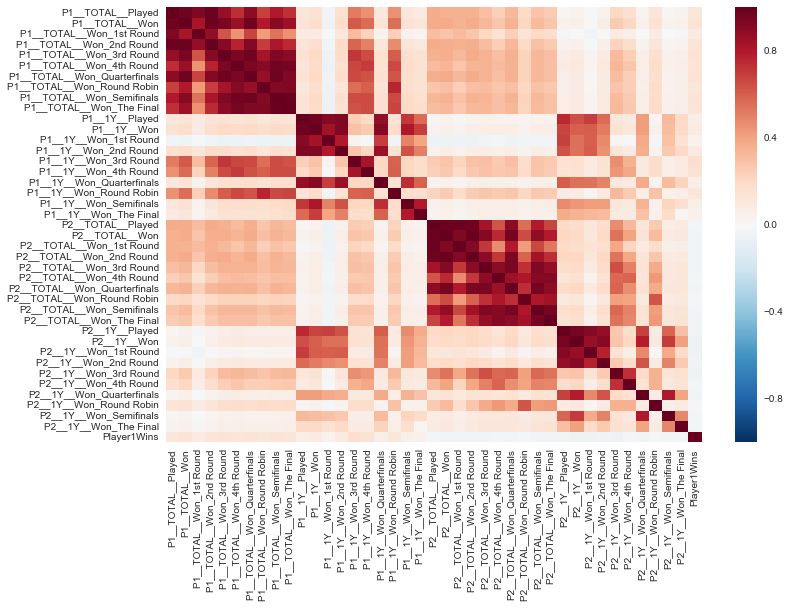

In [41]:
sns.heatmap(independant_df[columns + ["Player1Wins"]].corr())

Interesting things to note here:
* The `TOTAL__WON *` columns are quite correlated with one another (which does make sense)
* The `1Y__WON *` columns are far less correlated with one another, I guess a way to interpret this is that, as the period time we're considering is shorter, players are less likely to be consistent at winning for the various rounds?

If we look at the correlation between the players columns it's interesting to see that:
* The `P1__TOTAL *` or `P2__TOTAL *` are more correlated than the `P1__1Y * ` `P2__1Y *` columns, meaning if we look at a shorter horizon past performance then there will be more discrepancy between the performance of players that play against each other?

Also the target seems to be more correlated with the `Player1` columns rather than player2, is this a consequence of the fact that we picked the better ranked player as player 1? If we had randomly picked Player1 and 2, maybe it'd be more evenly correlated to the Player1 and Player2 columns
On the other hand this correlation is between a boolean vector and vectors with many different values, so maybe the correlations between `Player1Wins` and other columns isn't that meaningful

## 5.B Distributions

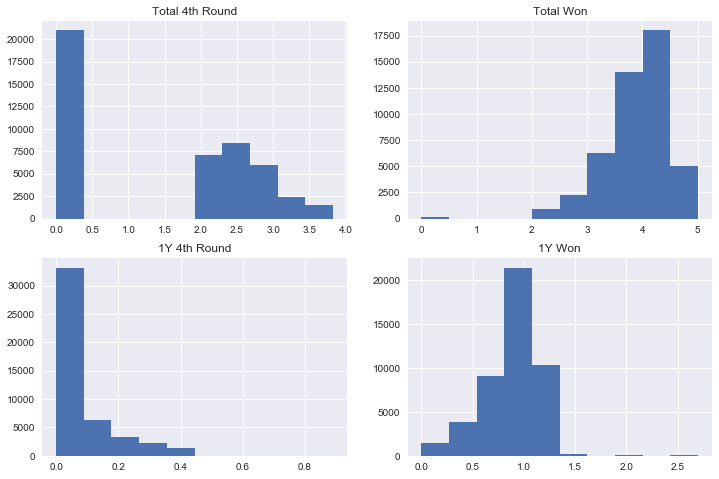

In [42]:
_, axes = plt.subplots(2, 2)
axes[0][0].set_title("Total 4th Round")
axes[1][0].set_title("1Y 4th Round")
axes[0][1].set_title("Total Won")
axes[1][1].set_title("1Y Won")
np.log10(independant_df["P1__TOTAL__Won_4th Round"] * 100 + 1).hist(ax=axes[0][0])
np.log10(independant_df["P1__1Y__Won_4th Round"] * 100 + 1).hist(ax=axes[1][0])
np.log10(independant_df["P1__TOTAL__Won"] * 100 + 1).hist(ax=axes[0][1])
np.log10(independant_df["P1__1Y__Won"] * 100 + 1).hist(ax=axes[1][1])

This is quite interesting:
* The 4th Round matches won statistics tend to have most of their mass around 0, and tail on the right: Only a relatively small subset of players make it to the 4th Round. This is even more pronounced if we look at the 1Y exp moving average
* The total numer of games won is slightly more normal, as everyone gets a change to win a match

## 5.C First go at modelling

In [43]:
lr = LogisticRegression()
lr.fit(independant_df[columns], independant_df.Player1Wins)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
lr.score(independant_df[columns], independant_df.Player1Wins)

0.69261678628217804

**We managed to beat the baseline!!!!!**